# ZFOURGE Bolometric Luminosity Functions

### Import and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM

F_comp = 80 # flux completeness %
min_count = 5 # Minimum number of sources in a bin
survey_area = 0.1111 # Total ZFOURGE survey area in square degrees
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
lum_bin_edges = np.arange(8, 14, 0.25) # luminosity bin edges
redshift_bins = [(0.00, 0.30), (0.30, 0.45), (0.45, 0.60), 
                 (0.60, 0.80), (0.80, 1.00), (1.00, 1.20),
                 (1.20, 1.70), (1.70, 2.00), (2.00, 2.50),
                 (2.50, 3.00), (3.00, 4.20), (4.20, 6.00)] # redshift bins

# All ZFOURGE sources
CDFS = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN3.csv')
COSMOS = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN3.csv')
UDS = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN3.csv')
df = pd.concat([CDFS, COSMOS, UDS], ignore_index=True)
print(f'Number of sources: {len(df)}')

# Use Mask
df = df[df['Use'] == 1]
print(f'Number of sources Use=1: {len(df)}')

# LIR Mask
df = df[df['LIR'] > 0]
print(f'Number of sources LIR>0: {len(df)}')

# F24 Mask
df = df[df['F24'] > 0]
print(f'Number of sources F24>0: {len(df)}')

# Redshift Mask
z_mask = (df['zpk'] >= redshift_bins[0][0]) & (df['zpk'] <= redshift_bins[-1][1])
df = df[z_mask]
print(f'Number of sources {redshift_bins[0][0]} <= z <= {redshift_bins[-1][1]}: {len(df)}')

# AGN Mask
AGN_mask = (df['irAGN'] == 1) | (df['radAGN'] == 1) | (df['xAGN'] == 1)
df = df[~AGN_mask]
print(f'Number of sources AGN=0: {len(df)}')

Number of sources: 73790
Number of sources Use=1: 37647
Number of sources LIR>0: 22997
Number of sources F24>0: 22997
Number of sources 0.0 <= z <= 6.0: 22967
Number of sources AGN=0: 22444


### Quiescent vs Starforming

In [ ]:
U_ab = 25 - 2.5*np.log10(df['FU']) # apparent magnitude -> AB magnitude
V_ab = 25 - 2.5*np.log10(df['FV']) # apparent magnitude -> AB magnitude
J_ab = 25 - 2.5*np.log10(df['FJ']) # apparent magnitude -> AB magnitude

U_V = U_ab - V_ab
V_J = V_ab - J_ab

mask_q = (U_V > 1.3) & (V_J < 1.6) & (U_V > 0.88*V_J+0.59)
print(f'Quiescent: {mask_q.sum()}')
print(f'Star-forming: {len(U_V) - mask_q.sum()}')

df = df[mask_q] # 1,502 - quiescent
# df = df[~mask_q] # 20,942 - star-forming

plt.scatter(V_J[mask_q], U_V[mask_q], s=1, label='Quiescent', color='red')
plt.scatter(V_J[~mask_q], U_V[~mask_q], s=1, label='Star-forming', color='blue')
plt.xlabel('$V - J$')
plt.ylabel('$U - V$')
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
plt.hlines(1.3, 0, 0.8, colors='red', linestyles='dashed')
plt.vlines(1.6, 2, 2.5, colors='red', linestyles='dashed')
plt.plot([0.8, 1.6], [1.3, 2.0], color='red', linestyle='dashed')
plt.legend()
plt.show()

### F24 Flux Limit

3.235
2.7796000000000003
2.6076
3.133
3.3952000000000004
3.2312000000000003
2.9228000000000005
3.747
3.139
2.8289999999999997
2.0830000000000006
2.008


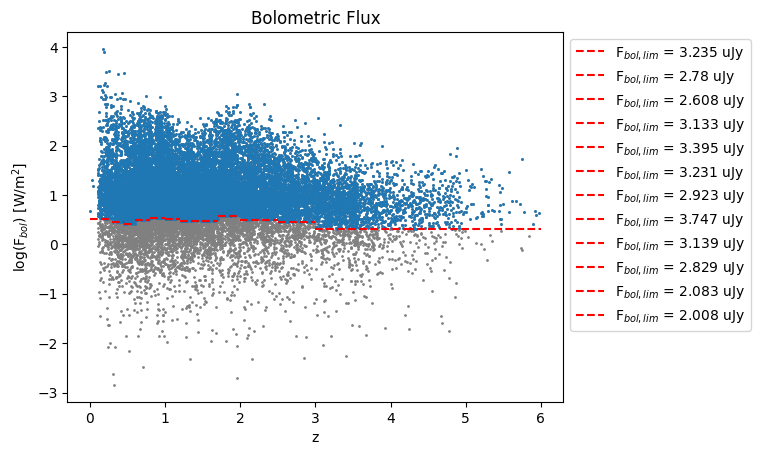

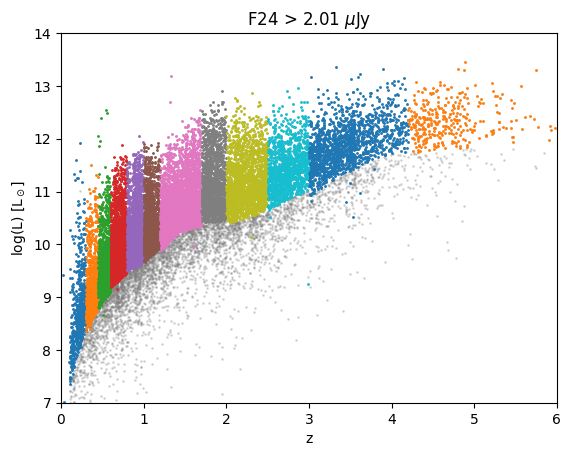

In [8]:
luminosity = df['LIR'].values.copy() # Solar Luminosity
luminosity *= 3.83*10**26 # Watts
z = df['zpk'].values.copy() # redshift

# # F24 Flux
# F24 = df['F24'].values.copy() # mJy
# F24 *= 10**3 # uJy
# F_lim = np.percentile(F24, 100-F_comp) # % of the data above perc
# # F_lim = 2.96 # uJy
# F_mask = F24 > F_lim
# print(f'Number of galaxies previous: {len(z)}')
# print(f'Number of galaxies F > {np.round(F_lim,2)} uJy: {len(z[F_mask])}')
# plt.scatter(z, np.log10(F24), s=1)
# plt.axhline(np.log10(F_lim), color='r', linestyle='--', label=f"F$_{{lim}}$ = {np.round((F_lim),2)} $\mu$Jy")
# plt.title('F24 Flux')
# plt.ylabel('log(F24) [uJy]')
# plt.xlabel('z')
# plt.legend()
# plt.show()

# Varying Bolo Flux
F24 = df['F24'].values.copy() # mJy
F24 *= 10**3 # uJy
F_mask = np.zeros(len(F24), dtype=bool)
for z_start, z_end in redshift_bins:
    mask_z = (z > z_start) & (z <= z_end)
    F_lim = np.percentile(F24[mask_z], 100-F_comp) # % of the data above perc
    print(F_lim)
    F_mask[mask_z] = F24[mask_z] > F_lim
    plt.hlines(np.log10(F_lim), color='r', linestyle='--', label=f"F$_{{bol,lim}}$ = {F_lim:.4} uJy", xmin=z_start, xmax=z_end)
plt.scatter(z, np.log10(F24), s=1, color='gray')
plt.scatter(z[F_mask], np.log10(F24[F_mask]), s=1)
plt.title('Bolometric Flux')
plt.ylabel('log(F$_{bol}$) [W/m$^2$]')
plt.xlabel('z')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# Luminosity
plt.scatter(z, np.log10(luminosity/(3.83*10**26)), s=1, color='grey', alpha=0.25)
for z_start, z_end in redshift_bins:
    mask_z = (z > z_start) & (z <= z_end)
    plt.scatter(z[F_mask & mask_z], np.log10(luminosity[F_mask & mask_z]/(3.83*10**26)), s=1)
plt.title(f'F24 > {np.round(F_lim,2)} $\mu$Jy')
plt.ylabel('log(L) [L$_\odot$]')
plt.xlabel('z')
plt.ylim(7, 14)
plt.xlim(redshift_bins[0][0], redshift_bins[-1][1])
plt.show()

### Data Correcting

1. Exclude sources with flux less than the minimum
2. Exclude luminosity bins less than the min count
3. Exclude luminosity bins on the faint side of the turn over point

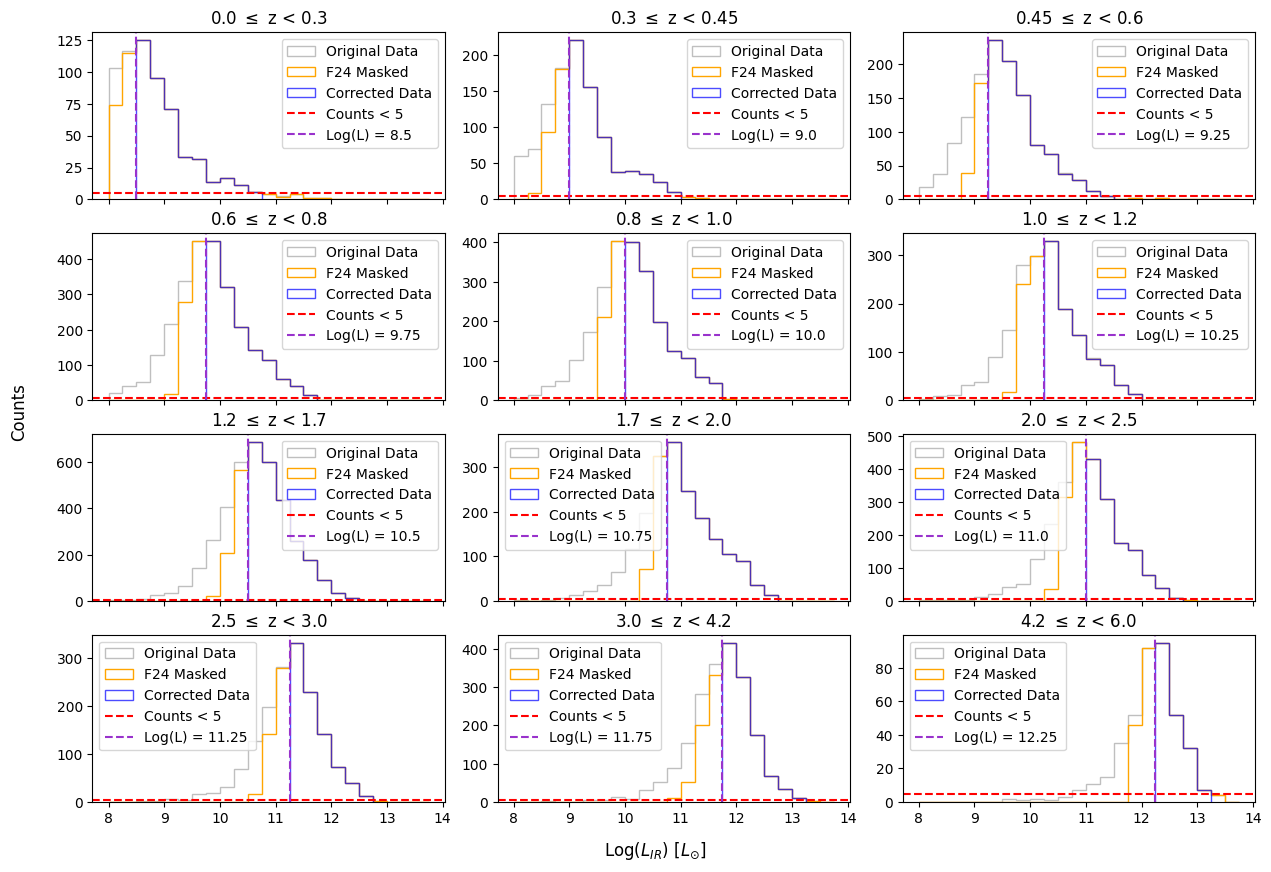

In [9]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True)
min_l = []
bin_edges = []

for ax, (z_start, z_end) in zip(axes.flatten(), redshift_bins):
    mask_z = (z > z_start) & (z <= z_end)
    
    # Bin the corrected (masked) data
    c, b = np.histogram(np.log10(luminosity[mask_z & F_mask]/(3.83*10**26)), bins=lum_bin_edges)
    centers = (b[:-1] + b[1:]) / 2 # luminosity bin centers
    
    # Mask the bins with less than the minimum count
    c_mask = c >= min_count
    for _ in range(2): # should only need to run twice
        nci = np.where(np.diff(np.where(c_mask)[0]) != 1)[0] # non-consecutive indices: mask non-consecutive True values
        c_mask[np.where(c_mask)[0][nci + 1]] = False
    
    # Mask faint end bins less than the turnover point
    peak_index = np.argmax(c)
    turnover_point = b[peak_index]
    if np.any(turnover_point <= min_l): # if the turnover point is less than or equal to the previous turnover points
        turnover_point = max(min_l)+np.diff(b)[0] # set the turnover point to the maximum + bin width
    b_mask = b[1:] >= turnover_point

    # Apply the masks
    b = b[1:][c_mask & b_mask]
    centers = centers[c_mask & b_mask]
    c = c[c_mask & b_mask]
    
    # Plot the data
    ax.hist(np.log10(luminosity[mask_z]/(3.83*10**26)), bins=lum_bin_edges, histtype='step', color='grey', label='Original Data', alpha=0.5)
    ax.hist(np.log10(luminosity[mask_z & F_mask]/(3.83*10**26)), bins=lum_bin_edges, histtype='step', color='orange', label='F24 Masked')
    ax.hist(centers, b, weights=c, histtype='step', label='Corrected Data', color='blue', alpha=0.7)
    ax.axhline(min_count, color='red', linestyle='--', label=f'Counts < {min_count}')
    ax.axvline(turnover_point, color='darkorchid', linestyle='--', label=f'Log(L) = {turnover_point}')
    ax.set_title(f'{z_start} $\leq$ z < {z_end}')
    ax.legend()
    
    # Save data
    min_l.append(turnover_point)
    bin_edges.append(b)

fig.supylabel('Counts', x=0.07)
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
plt.subplots_adjust(hspace=0.2, wspace=0.15)
plt.show()    

### Calculate Maximum Volume

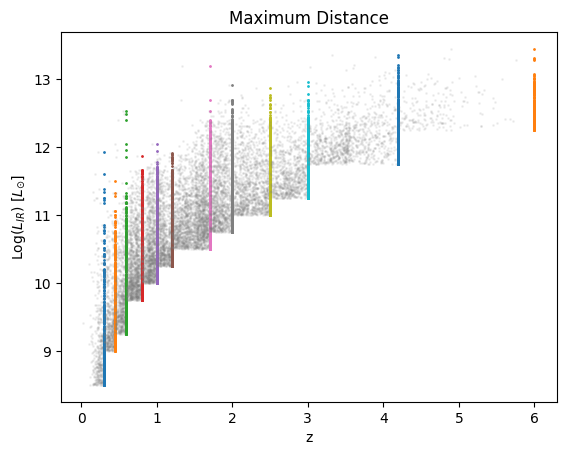

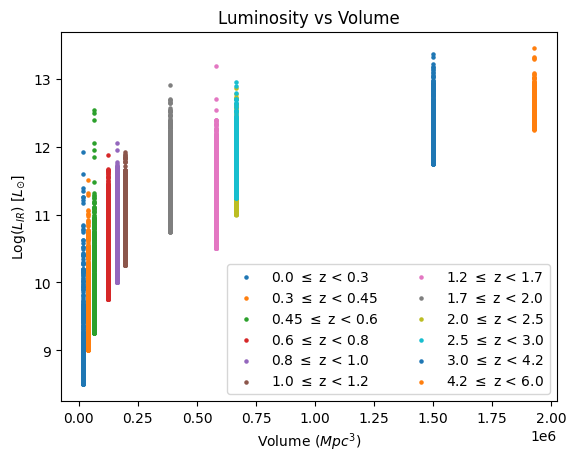

In [10]:
all_data = []

for (z_start, z_end), lmin in zip(redshift_bins, min_l):
    mask_z = (z > z_start) & (z <= z_end)
    
    # Data bin
    lum_bin = np.log10(luminosity[mask_z & F_mask]/(3.83*10**26))
    z_bin = z[mask_z & F_mask]
    
    # Mask the faint end
    mask_l = lum_bin >= lmin
    lum_bin = lum_bin[mask_l]
    z_bin = z_bin[mask_l]
    
    # Maximum distance of all sources is the end of the redshift bin
    zmaxs = z_bin.copy()
    zmaxs[:] = z_end
    
    # Comoving distance of the minimum and maximum redshifts
    dmin = cosmo.comoving_distance(z_start).value # Mpc
    dmaxs = cosmo.comoving_distance(zmaxs).value # Mpc
    
    # Calculate the minimum volume of the redshift bin
    vmin = 4/3 * np.pi * dmin**3 # Mpc^3

    # Calculate the maximum volume of each luminosity bin
    vmaxs = 4/3 * np.pi * dmaxs**3 # Mpc^3
    
    # Total volume probed accounting for survey area
    vol = (vmaxs - vmin) * (survey_area / 41253) # Mpc^3
    
    all_data.append([vol, lum_bin])
    plt.scatter(z_bin, lum_bin, s=1, color='grey', alpha=0.1)
    plt.scatter(zmaxs, lum_bin, s=1)
plt.title('Maximum Distance')
plt.ylabel('Log($L_{IR}$) [$L_{\odot}$]')
plt.xlabel('z')
plt.show()
     
plt.title('Luminosity vs Volume')
for (v, m), (z_start, z_end) in zip(all_data, redshift_bins):
    plt.scatter(v, m, s=5, label=f'{z_start} $\leq$ z < {z_end}')
plt.xlabel('Volume $(Mpc^3)$')
plt.ylabel('Log($L_{IR}$) [$L_{\odot}$]')
plt.legend(loc='lower right', ncols=2)
plt.show()

### Luminosity Function

0.0 <= z < 0.3, [8.625, 8.875, 9.125, 9.375, 9.625, 9.875, 10.125, 10.375, 10.625]
0.3 <= z < 0.45, [9.125, 9.375, 9.625, 9.875, 10.125, 10.375, 10.625, 10.875]
0.45 <= z < 0.6, [9.375, 9.625, 9.875, 10.125, 10.375, 10.625, 10.875, 11.125, 11.375]
0.6 <= z < 0.8, [9.875, 10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625]
0.8 <= z < 1.0, [10.125, 10.375, 10.625, 10.875, 11.125, 11.375, 11.625]
1.0 <= z < 1.2, [10.375, 10.625, 10.875, 11.125, 11.375, 11.625, 11.875]
1.2 <= z < 1.7, [10.625, 10.875, 11.125, 11.375, 11.625, 11.875, 12.125, 12.375]
1.7 <= z < 2.0, [10.875, 11.125, 11.375, 11.625, 11.875, 12.125, 12.375, 12.625]
2.0 <= z < 2.5, [11.125, 11.375, 11.625, 11.875, 12.125, 12.375, 12.625]
2.5 <= z < 3.0, [11.375, 11.625, 11.875, 12.125, 12.375, 12.625]
3.0 <= z < 4.2, [11.875, 12.125, 12.375, 12.625, 12.875, 13.125]
4.2 <= z < 6.0, [12.375, 12.625, 12.875, 13.125]


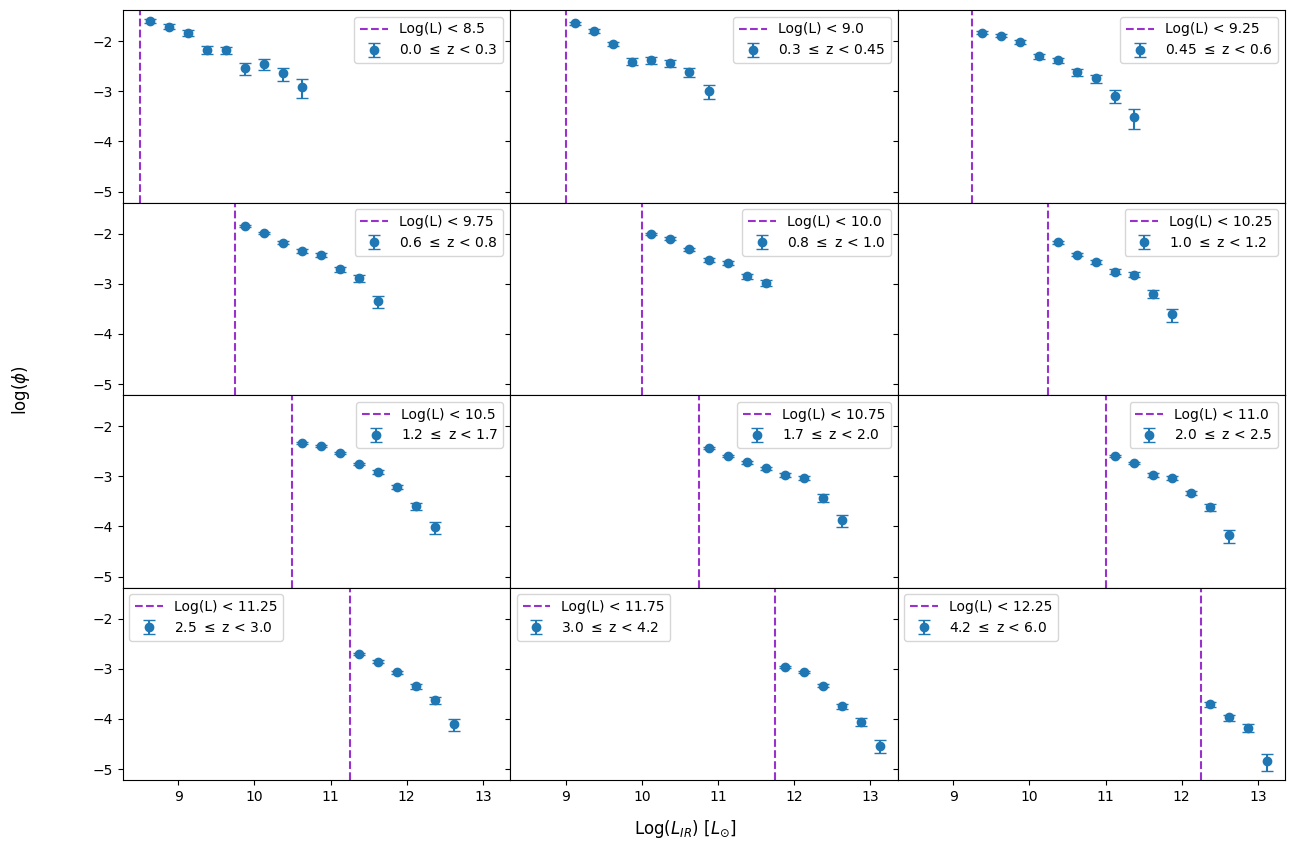

In [11]:
lum_centers, phi, phi_e = [], [], []

# Volume and luminosity are already binned by redshift
for (vol, lum), bin in zip(all_data, bin_edges):
    
    if len(bin) <= 1:
        lum_centers.append(np.array([]))
        phi.append(np.array([]))
        phi_e.append(np.array([]))
        continue
    delta_log_l = np.diff(bin)[0]
    
    lum_centers_z, phi_z, phi_e_z = [], [], []

    # Bin by luminosity
    for lum_start, lum_end in zip(bin, bin[1:]):
        mask = (lum >= lum_start) & (lum < lum_end)
        vol_lum_bin = vol[mask]
        
        # Calculate the number density
        phi_val = (1 / delta_log_l) * np.sum(1 / vol_lum_bin)
        phi_err = (1 / delta_log_l) * np.sqrt(np.sum(1 / (vol_lum_bin ** 2)))
        
        # Save the luminosity bin and number density
        lum_centers_z.append((lum_start + lum_end) / 2)
        phi_z.append(phi_val)
        phi_e_z.append(phi_err)
    
    # Save the luminosity bins and number densities
    lum_centers.append(lum_centers_z)
    phi.append(phi_z)
    phi_e.append(np.array(phi_e_z))

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax, min_ls in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten(), min_l):
    print(f'{z_start} <= z < {z_end}, {(lum)}')
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.axvline(min_ls, color='darkorchid', linestyle='--', label=f'Log(L) < {round(min_ls, 2)}')
    ax.legend()
    
fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)

### Schechter Function

0.0 <= z < 0.3 Function fit:
Log L_star = 9.51 +/- 0.12
Log phi_star = -1.72 +/- 0.06
Alpha = 1.2


0.3 <= z < 0.45 Function fit:
Log L_star = 9.71 +/- 0.14
Log phi_star = -1.65 +/- 0.09
Alpha = 1.2


0.45 <= z < 0.6 Function fit:
Log L_star = 10.4 +/- 0.09
Log phi_star = -1.99 +/- 0.04
Alpha = 1.2


0.6 <= z < 0.8 Function fit:
Log L_star = 10.77 +/- 0.12
Log phi_star = -1.99 +/- 0.06
Alpha = 1.2


0.8 <= z < 1.0 Function fit:
Log L_star = 11.04 +/- 0.13
Log phi_star = -2.15 +/- 0.06
Alpha = 1.2


1.0 <= z < 1.2 Function fit:
Log L_star = 11.11 +/- 0.17
Log phi_star = -2.29 +/- 0.09
Alpha = 1.2


1.2 <= z < 1.7 Function fit:
Log L_star = 11.6 +/- 0.05
Log phi_star = -2.47 +/- 0.02
Alpha = 1.2


1.7 <= z < 2.0 Function fit:
Log L_star = 12.07 +/- 0.0
Log phi_star = -2.7 +/- 0.03
Alpha = 1.2


2.0 <= z < 2.5 Function fit:
Log L_star = 11.92 +/- 0.0
Log phi_star = -2.7 +/- 0.02
Alpha = 1.2


2.5 <= z < 3.0 Function fit:
Log L_star = 11.98 +/- 0.0
Log phi_star = -2.72 +/- 0.01
Alpha = 1.2

C:\Users\n10480129\AppData\Local\Temp\ipykernel_17908\1145377853.py:53: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
C:\Users\n10480129\AppData\Local\Temp\ipykernel_17908\1145377853.py:55: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *p_down)),
C:\Users\n10480129\AppData\Local\Temp\ipykernel_17908\1145377853.py:56: RuntimeWarning: divide by zero encountered in log10
  np.log10(schechter_luminosity(long_lum, *p_up)),


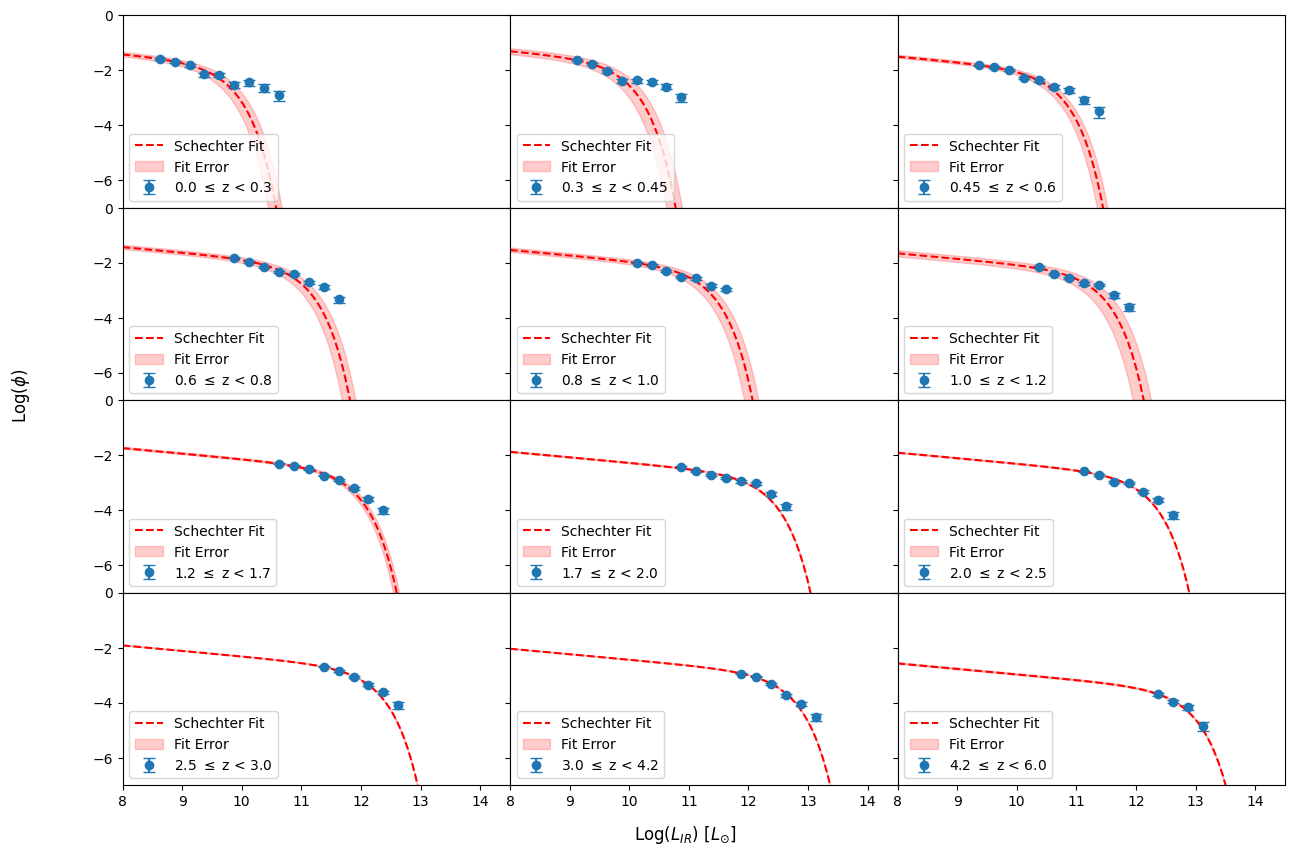

In [12]:
def schechter_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.2) * np.exp(-L / L_star)

schecter_params = []
schecter_errors = []
schechter_funcs = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):

    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        schecter_params.append([])
        schecter_errors.append([])
        continue
    
    lum = np.power(10, lum)
    
    # Attempt to fit the data
    p0=[lum[0], 0.003]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    try:
        params, covars = curve_fit(schechter_luminosity, lum, p, p0=p0, bounds=bounds, maxfev=1000)
        perr = np.sqrt(np.diag(covars))
        p_up = params + perr
        p_down = np.abs(params - perr)
        schecter_params.append(params)
        schecter_errors.append(perr)
        schechter_funcs.append(schechter_luminosity)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        schecter_params.append([])
        schecter_errors.append([])
        schechter_funcs.append(None)
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        schecter_params.append([])
        schecter_errors.append([])
        schechter_funcs.append(None)
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round(np.abs(np.log10(params[0]) - np.log10(params[0] - perr[0])),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round(np.abs(np.log10(params[1]) - np.log10(params[1] - perr[1])),2)}')
    print(f'Alpha = 1.2')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(8, 14.5, 100)
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(schechter_luminosity(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(schechter_luminosity(long_lum, *p_down)),
        np.log10(schechter_luminosity(long_lum, *p_up)),
        color='red', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(8, 14.5)

fig.supxlabel('Log($L_{IR}$) [$L_{\odot}$]', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Saunders Function

In [ ]:
def saunders_luminosity(L, L_star, phi_star):
    return phi_star * (L / L_star) ** (1-1.3) * np.exp(-1 / (2 * 0.7 ** 2) * (np.log10(1 + (L / L_star)))**2)

saunder_params = []
saunder_error = []
saunder_funcs = []

fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    
    if len(lum) == 0:
        print(f'No data for {z_start} <= z < {z_end}')
        saunder_params.append([])
        saunder_error.append([])
        continue
    
    lum = np.power(10, lum)
    p0 = [lum[0], 1e-3]
    bounds = ([lum[0]/2, 1e-6], [lum[-1]*2, 1e-1])
    
    # Attempt to fit the data
    try:
        params, covars = curve_fit(saunders_luminosity, lum, p, p0=p0, bounds=bounds, maxfev=10000)
        perr = np.sqrt(np.diag(covars))
        p_up = params + perr
        p_down = np.abs(params - perr)
        saunder_params.append(params)
        saunder_error.append(perr)
        saunder_funcs.append(saunders_luminosity)
    except RuntimeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Maxfev reached.')
        saunder_params.append([])
        saunder_error.append([])
        saunder_funcs.append(None)
        continue
    except TypeError:
        print(f'Failed to fit {z_start} <= z < {z_end}. Params: {len(params)} > data points: {len(lum)}.')
        saunder_params.append([])
        saunder_error.append([])
        saunder_funcs.append(None)
        continue
    
    print(f'{z_start} <= z < {z_end} Function fit:')
    print(f'Log L_star = {np.round(np.log10(params[0]),2)} +/- {np.round(np.abs(np.log10(params[0]) - np.log10(params[0] - perr[0])),2)}')
    print(f'Log phi_star = {np.round(np.log10(params[1]),2)} +/- {np.round(np.abs(np.log10(params[1]) - np.log10(params[1] - perr[1])),2)}')
    print(f'Alpha = 1.3')
    print(f'Sigma = 0.7')
    print('\n')
    
    # Plot the data
    long_lum = np.logspace(8, 14.5, 100)
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(np.log10(lum), np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.plot(np.log10(long_lum), np.log10(saunders_luminosity(long_lum, *params)), color='blue', label='Saunders Fit', linestyle='--')   
    ax.fill_between(np.log10(long_lum), 
        np.log10(saunders_luminosity(long_lum, *p_down)), 
        np.log10(saunders_luminosity(long_lum, *p_up)), 
        color='blue', alpha=0.2, label='Fit Error')
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(8, 14.5)

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Schechter & Saunders

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)

# Schechter Function
for ax, func, params, perr in zip(axes.flatten(), schechter_funcs, schecter_params, schecter_errors):
    long_lum = np.logspace(8, 14.5, 100)
    p_up = params + perr
    p_down = np.abs(params - perr)
    ax.plot(np.log10(long_lum), np.log10(func(long_lum, *params)), color='red', label='Schechter Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(func(long_lum, *p_down)),
        np.log10(func(long_lum, *p_up)),
        color='red', alpha=0.2, label='Fit Error')

# Saunders Function
for ax, func, params, perr in zip(axes.flatten(), saunder_funcs, saunder_params, saunder_error):
    long_lum = np.logspace(8, 14.5, 100)
    p_up = params + perr
    p_down = np.abs(params - perr)
    ax.plot(np.log10(long_lum), np.log10(func(long_lum, *params)), color='blue', label='Saunders Fit', linestyle='--')
    ax.fill_between(np.log10(long_lum),
        np.log10(func(long_lum, *p_down)),
        np.log10(func(long_lum, *p_up)),
        color='blue', alpha=0.2, label='Fit Error')

# Luminosity Function
for (z_start, z_end), lum, p, e, ax in zip(redshift_bins, lum_centers, phi, phi_e, axes.flatten()):
    yerr = [np.log10(p) - np.log10(p - e), np.log10(p + e) - np.log10(p)]
    ax.errorbar(lum, np.log10(p), yerr=yerr, label=f'{z_start} $\leq$ z < {z_end}', fmt='o', capsize=4)
    ax.legend(loc='lower left')
    ax.set_ylim(-7, 0)
    ax.set_xlim(8, 14.5)

fig.supxlabel('log10(Luminosity [$W$])', y=0.05)
fig.supylabel('Log($\phi$)', x=0.05)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

### Parameter Evolution

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)

# Schechter Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, schecter_params, schecter_errors)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, p[0], yerr=e[0], fmt='o', capsize=4, color='red', label='Schechter' if i == 4 else "")
        ax[1].errorbar(z_center, p[1], yerr=e[1], fmt='o', capsize=4, color='red')
    except IndexError:
        continue

# Saunders Evolution
for i, ((z_start, z_end), p, e) in enumerate(zip(redshift_bins, saunder_params, saunder_error)):
    z_center = (z_start + z_end) / 2
    try:
        ax[0].errorbar(z_center, p[0], yerr=e[0], fmt='o', capsize=4, color='blue', label='Saunders' if i == 4 else "")
        ax[1].errorbar(z_center, p[1], yerr=e[1], fmt='o', capsize=4, color='blue')
    except IndexError:
        continue

ax[0].set_ylabel('$L_{*}$')
ax[1].set_ylabel('$\phi_{*}$')
ax[0].legend(loc='lower right')
ax[1].set_xlim(0, 5.5)
ax[0].set_ylim(10**7.5, 10**13)
ax[1].set_ylim(10**-5, 10**-1.5)
ax[0].set_yscale('log')
ax[1].set_yscale('log')

fig.supxlabel('z')
plt.subplots_adjust(hspace=0)
plt.show()

### Class Evolution

In [ ]:
redshift_centers = np.mean(redshift_bins, axis=1)
luminosity_centers = np.arange(8.5, 13.5, 0.5) # luminosity bin edges
colors = plt.cm.gist_rainbow(np.linspace(0,1,len(luminosity_centers)))

# Iterate over the luminosity bins
est_phi = []
est_phi_e = []
new_z = []
for l_center in luminosity_centers:
    est_phi_z = []
    est_phi_e_z = []
    new_z_z = []

    # Iterate over the redshift bins:
    for z_val, params, perr in zip(redshift_centers, saunder_params, saunder_error):
    # for z_val, params, perr in zip(redshift_centers, schecter_params, schecter_errors):
        if len(params) == 0:
            continue
    
        # Calculate the number density of the missing luminosity bin
        est_phi_z.append(saunders_luminosity(10**l_center, *params))
        est_phi_e_z.append([saunders_luminosity(10**l_center, *(params - perr)), saunders_luminosity(10**l_center, *(params + perr))])
        # est_phi_z.append(schechter_luminosity(10**l_center, *params))
        # est_phi_e_z.append([schechter_luminosity(10**l_center, *(params - perr)), schechter_luminosity(10**l_center, *(params + perr))])
        new_z_z.append(z_val)
            
    est_phi.append(est_phi_z)
    est_phi_e.append(est_phi_e_z)
    new_z.append(new_z_z)
    
# Plot the estimated number densities
for nz, nphi, lcent, c, nphie in zip(new_z, est_phi, luminosity_centers, colors, est_phi_e):
    nphie = np.array(nphie).T
    nphi = np.array(nphi)
    yerr = [np.log10(nphi) - np.log10(nphi - nphie[0]), np.log10(nphi + nphie[1]) - np.log10(nphi)]
    plt.errorbar(nz, np.log10(nphi), yerr=np.abs(yerr), capsize=4, color=c, label=f'{lcent}', linestyle='--', marker='x')
    
plt.legend(ncols=2)
plt.xlabel('Redshift', fontsize=20)
plt.ylabel('log($\phi$) [Mpc$^{-3}$ dex$^{-1}$]', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks([-10, -8, -6, -4, -2], fontsize=20)
# plt.yticks([-200, -100, 0], fontsize=20)
plt.tight_layout()
plt.show()

# Export Data

In [ ]:
file_name = 'ZFOURGE_QUI'
np.savez(file_name, 
    x=np.array(lum_centers, dtype=object), 
    y=np.array(phi, dtype=object), 
    e=np.array(phi_e, dtype=object),
    z=np.array(redshift_bins, dtype=object),
    m=np.array(min_l, dtype=object),
    schech_p=np.array(schecter_params, dtype=object),
    saunder_p=np.array(saunder_params, dtype=object),
    schech_e=np.array(schecter_errors, dtype=object),
    saunder_e=np.array(saunder_error, dtype=object),
    schech_f=np.array(schechter_funcs, dtype=object),
    saunder_f=np.array(saunder_funcs, dtype=object))